# Classification of HIE Grading using resnet18 and Kfold cross validation
- Here the model is doing k fold cross validation and we choose the best model based on AUC reusult of epochs. Then test the best model on the test dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, models
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image           #PIL is python image library
from IPython.display import display
from sklearn import metrics             #for evaluation of the system
import time
from typing import List, Dict, Tuple
import os
import glob
import nums_from_string                  #extracting annotation number based on file name
import copy
import pickle
import wandb
import random
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, auc, accuracy_score, f1_score
from torcheval.metrics.aggregation.auc import AUC
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC
import wandb
from tqdm import tqdm
from itertools import chain
%matplotlib inline

C:\Users\krezaei\.conda\envs\vasie_kimia\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
project_name = '29022024_resnet18_HIE'

In [3]:
wandb.login()

wandb: Currently logged in as: kimia-rezaei90 (kimia_rezaei). Use `wandb login --relogin` to force relogin


True

# Image preprocessing
- change data to tensor
- Normlize: Calculate the mean and standard deviation by averaging the values for each color channel across all the images in the dataset  
- resize the images

In [4]:
# "seed" remember the random chosen data so that we can run our notebook many times and use the same data
random_seed = 42          
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [5]:
# build transformer to transform images to tensors
transformer =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3168, 0.7164, 0.4096), (0.1729, 0.0835, 0.1050)),              # mean and std are 0.5
    transforms.Resize((224,224), antialias=True)                              # resize the images
])

In [6]:
#get annotaion file
annotation_df = pd.read_csv('data/HIE grades.csv')
annotation_df = annotation_df[['Study ID', 'binary grade']]

In [7]:
#get images path
files_path = glob.glob('13122023_spectrogram_HIE/*/stitched')

In [8]:
# make a dataset reader based on my folder arrangment
class my_image_dataset(Dataset):
    def __init__(self, root_dir, transformer, annotation_file):
        self.root_dir = root_dir
        self.annotation = annotation_file
        self.transformer = transformer
        self.samples = []
        
        #define each image path and its label(class 0 or 1)
        for image_path in self.root_dir:
            baby_code = image_path.split('\\')[1]  #get baby code
            class_label = (self.annotation[self.annotation['Study ID'] == baby_code]['binary grade']).iloc[0]     #get baby annotation
            self.samples.extend([[image_path, class_label]] )   # add all items of the loop to one list and add labels for each image
    
    # getting number of data later using len(dataset) function
    def __len__(self):
            return len(self.samples)

    # read images and their labels and apply transformer on them    
    def __getitem__(self, idx):
        image_path, class_label = self.samples[idx]
        image = Image.open(image_path)              #read the image
        image = self.transformer(image)            # apply transformer on the image
        return image, class_label

# Define the model

**calculate output size**                   
output size= ((input_size-kernel_size+(2*padding))/stride)+1  

In [9]:
# now define the model as a class
class my_resnet18(nn.Module):
    def __init__(self):
        super().__init__()
        
        my_model = models.resnet18(pretrained=True)   #load resnet18 model
        num_features = my_model.fc.in_features     #extract fc layers features
        my_model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)
        
        self.model = my_model

    def forward(self, x):
        return self.model(x)

In [10]:
my_model = my_resnet18()
my_model

C:\Users\krezaei\.conda\envs\vasie_kimia\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\krezaei\.conda\envs\vasie_kimia\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


my_resnet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

# Move data to GPU

In [11]:
#function for moving data and model to a chosen device(gpu or cpu)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda:0'
def to_device(data, device):    
    if isinstance(data, (list, tuple, tuple)):
        return [to_device(x, device) for x in data]    
    return data.to(device, non_blocking=True)

In [12]:
#create a class to wrap our existing data loaders and move batches of data to the selected device.
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    'Yield a batch of data after moving it to device'    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)     #number of batches           

In [13]:
model_gpu = to_device(my_model,device)

# Train and validate the model

In [14]:
number_folds = 5
epochs = 30
lr = 1e-4
opt_func = torch.optim.Adam

In [15]:
# Taining the model
start = time.time()           #count the Execution time
#save the initial model to start from the begining for each fold

# data frame to save all patients result
result_df = pd.DataFrame([], dtype=float)

# K fold cross validation
kf = KFold(n_splits=number_folds)
for fold, (train_index, test_index) in enumerate(kf.split(files_path)):
    # splite data into folds based on baby numbers(path)
    train_folders = [files_path[x] for x in train_index]
    test_folders = [files_path[x] for x in test_index] 
    
    train_set_files_full = [sorted(glob.glob(os.path.join(path,'*.png'))) for path in train_folders]
    test_set_files = [sorted(glob.glob(os.path.join(path,'*.png'))) for path in test_folders ] 
    
    # flatten the lists
    train_set_files_full = list(chain(*train_set_files_full))
    test_set_files = list(chain(*test_set_files))
    
    # get name of test patients and their number of samples
    signal_name_info = list([dataname.split('\\')[1] for dataname in test_folders])    # all test samples patient name
    samples_test_set = list([dataname.split('\\')[1] for dataname in test_set_files])    # all test samples patient name
    size_patients = [samples_test_set.count(item) for item in signal_name_info]              # number of each patient's sample
    
    # Create your custom dataset
    train_ds_full = my_image_dataset(root_dir=train_set_files_full, transformer=transformer, annotation_file=annotation_df)
    test_ds = my_image_dataset(root_dir=test_set_files, transformer=transformer, annotation_file=annotation_df)

    #split train and validation set(for internal cross validation)
    validation_size = int(0.3* len(train_ds_full))
    train_size = len(train_ds_full) - validation_size
    train_ds, val_ds = random_split(train_ds_full, [train_size, validation_size])

    #seperating data into batches
    train_dl = DataLoader(train_ds, batch_size=254, shuffle=True)
    validation_dl = DataLoader(val_ds, batch_size=254)
    test_dl = DataLoader(test_ds, batch_size=254)

    # move data to GPU
    train_loader = DeviceDataLoader(train_dl,device)
    validation_loader = DeviceDataLoader(validation_dl,device)
    test_loader = DeviceDataLoader(test_dl,device)

    #save the initial model to start from the begining for each fold
    model = copy.deepcopy(model_gpu)
    optimizer = opt_func(model.parameters(), lr = lr)           #parameter optimizer function
    
    # initialize variables
    best_auc = 0
    best_model = None
    
    test_loss = 0.0
    batch_out_test = []
    batch_labels_test = []

    # weight and biases config
    wandb.init(
        # Set the project where this run will be logged
        project="05032024_resnet18_smalldataset_HIE",
        # Track hyperparameters and run metadata
        name=f"fold{fold}",
        config={
            "learning_rate": 1e-4,
            "epochs": 50,
        },
    )
    
    for epoch in range(epochs):
        
        train_loss = 0.0
        val_loss = 0.0
        batch_out = []
        batch_labels = []

        # Training Phase 
        model.train()
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate the average loss for the epoch
        epoch_loss_train = train_loss / len(train_loader)

        # Validation phase
        model.eval()    
        with torch.no_grad():
            for batch in validation_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                batch_labels.append(labels)              # append labels of all batches
                out_V = model(images)
                batch_out.append(out_V)                       # append output of all batches
                loss_V = F.cross_entropy(out_V, labels)

                # sum of all losses
                val_loss += loss_V.item()

        # calculate average loss for each epoch
        epoch_loss_val = val_loss / len(validation_loader)

        # concatenate output and labels of each epoch
        epoch_labels = torch.cat(batch_labels)
        epoch_out = torch.cat(batch_out) 

        # calculate evaluation metrics
        # prediction probability and labels
        #_ , soft_pred = torch.max(epoch_out, dim=1)     # use soft max for prediction labels
        prob_val = torch.softmax(epoch_out, dim=1)[:, 1]

        # AUC
        auc_metrics = BinaryAUROC()
        auc_val = auc_metrics(prob_val, epoch_labels)

        # save the best model based on validation AUC
        if auc_val >= best_auc:
            best_auc = auc_val
            best_model = model
            best_epoch = epoch
            
        # weight and biases logs to 
        wandb.log({"epoch": epoch, "train loss": epoch_loss_train, "validation loss": epoch_loss_val, "AUC": auc_val.item()})

    # Test phase
    test_loss = 0.0
    batch_out_test = []
    batch_labels_test = []
    best_model.eval()    
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            batch_labels_test.append(labels)              # append labels of all batches
            out_T = best_model(images)
            batch_out_test.append(out_T)                       # append output of all batches
            loss_T = F.cross_entropy(out_T, labels)

            # sum of all losses
            test_loss += loss_T.item()

    # calculate average loss for each epoch
    epoch_loss_test = test_loss / len(test_loader)

    # concatenate output and labels of each epoch
    epoch_labels_test = torch.cat(batch_labels_test)
    epoch_out_test = torch.cat(batch_out_test) 
    
    # calculate evaluation metrics
    # prediction probability and labels
    prob_test = torch.softmax(epoch_out_test, dim=1)[:, 1]
    # get probabilities for each patient
    prob_split = torch.split(prob_test, size_patients)                # split probabilities of each patient(based on patient number of samples)
    patient_prob = torch.tensor([torch.mean(i) for i in prob_split])      # for each patients get everage of all probabilities
    patients_pred_label = (patient_prob>=0.5).long()
    
    # get labels for each patient
    labels_split = torch.split(epoch_labels_test, size_patients)              # split labels of each patient(based on patient number of samples)
    target = torch.tensor([torch.mode(i)[0] for i in labels_split]) # for each patients get majority of all labels

    # Accuracy
    acc_metrics = BinaryAccuracy().to(device)
    acc = acc_metrics(patient_prob, target)
    # AUC
    auc_metrics = BinaryAUROC()
    auc = auc_metrics(patient_prob, target)

    # make a dataframe from results
    df_data = {'names':signal_name_info, 'prob':patient_prob.cpu().numpy(), 'prediction': patients_pred_label.cpu().numpy() , 'grade': target.cpu().numpy()}    
    fold_df = pd.DataFrame(df_data)    #each fold dataframe
    result_df = pd.concat([result_df, fold_df], ignore_index=True)   # concatenate all folds results
    
    print('test_loss:', epoch_loss_test , 'test_acc:', acc.item() ,'test_AUC', auc.item(), 'prediction', prob_test, 'target', epoch_labels_test )
    print('names:', signal_name_info, 'target:', target, 'pred_label:', patients_pred_label)
      
wandb.finish()
end = time.time()
total_time = end - start
print(f'Total Execution Time: {total_time}')

test_loss: 2.0498359501361847 test_acc: 0.625 test_AUC 0.6363636255264282 prediction tensor([9.8846e-01, 9.5705e-01, 1.3272e-01,  ..., 2.5065e-04, 9.9573e-01,
        9.9516e-01], device='cuda:0') target tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
naems: ['101_A2', '102_A1', '102_A2', '107_A1', '107_A2', '113_A2', '119_A2', '120_A2', '126_A2', '127_A2', '128_A2', '138_A2', '142_A1', '144_A1', '145_A2', '147_A2', '151_A2', '153_A1', '162_A2', '175_A2', '178_A2', '17_A2', '180_A1', '185_A2'] target: tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]) pred_label: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1])


AUC,▁▇████████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC,0.99753
epoch,29
train loss,0.00011
validation loss,0.06568


test_loss: 2.8690732518831887 test_acc: 0.5 test_AUC 0.5454545021057129 prediction tensor([1.0000, 1.0000, 1.0000,  ..., 0.4974, 0.8769, 0.9399], device='cuda:0') target tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
naems: ['186_A2', '188_A2', '18_A2', '201_A2', '205_A2', '206_A1', '213_A2', '216_A2', '217_A2', '224_A1', '224_A2', '225_A1', '227_A2', '230_A1', '231_A1', '232_A2', '233_A2', '235_A2', '236_A1', '236_A2', '240_A2', '245_A2', '24_A1', '256_A2'] target: tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]) pred_label: tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])


AUC,▁█████████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC,0.99944
epoch,29
train loss,0.0002
validation loss,0.03241


test_loss: 1.8090836306413014 test_acc: 0.695652186870575 test_AUC 0.8000000715255737 prediction tensor([8.6203e-04, 2.5800e-02, 1.3910e-04,  ..., 3.4516e-03, 3.1368e-03,
        7.3634e-05], device='cuda:0') target tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
naems: ['25_A1', '276_A1', '279_A1', '280_A1', '313_A1', '314_A1', '327_A1', '32_A1', '333_A1', '337_A1', '339_A1', '33_A1', '347_A1', '349_A1', '351_A1', '353_A1', '35_A2', '360_A1', '366_A1', '374_A1', '37_A1', '393_A1', '411_A1'] target: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]) pred_label: tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])


AUC,▁▇▇███████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC,0.99801
epoch,29
train loss,8e-05
validation loss,0.06715


test_loss: 2.512111554543177 test_acc: 0.47826087474823 test_AUC 0.579365074634552 prediction tensor([9.9997e-01, 9.9464e-01, 9.8801e-01,  ..., 7.3541e-01, 7.4579e-03,
        2.5214e-04], device='cuda:0') target tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
naems: ['425_A1', '434_A1', '446_A1', '45_A2', '460_A1', '476_A1', '477_A1', '48_A1', '4_A2', '504_A1', '506_A1', '50_A2', '512_A1', '517_A1', '51_A1', '529_A1', '53_A1', '540_A1', '546_A1', '54_A1', '558_A1', '559_A1', '560_A1'] target: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]) pred_label: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0])


AUC,▁▇▇███████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC,0.9986
epoch,29
train loss,0.00011
validation loss,0.05027


test_loss: 1.2319714824358623 test_acc: 0.739130437374115 test_AUC 0.8230769038200378 prediction tensor([0.0277, 0.0011, 0.0047,  ..., 0.9984, 0.9949, 0.9993], device='cuda:0') target tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
naems: ['572_A1', '576_A1', '57_A1', '57_A2', '590_A1', '601_A1', '620_A1', '62_A2', '631_A1', '63_A1', '647_A1', '710_A1', '713_A1', '730_A1', '734_A1', '751_A1', '75_A2', '79_A2', '85_A1', '95_A1', '95_A2', '96_A2', '97_A2'] target: tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]) pred_label: tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])


AUC,▁▇█▆██████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC,0.99867
epoch,29
train loss,0.00011
validation loss,0.05384


Total Execution Time: 4702.929641008377


In [25]:
result_df

,names,prob,prediction,grade
0,101_A2,0.696666,1,1
1,102_A1,0.000147,0,0
2,102_A2,0.725589,1,0
3,107_A1,0.902702,1,1
4,107_A2,0.299990,0,0
...,...,...,...,...
112,85_A1,0.000390,0,0
113,95_A1,0.405007,0,0
114,95_A2,0.999996,1,1
115,96_A2,0.398784,0,1


In [24]:
result_df.to_csv('models/05032024_resnet18_HIE_result.csv', index=False)

# Method evaluation

In [16]:
accuracy = accuracy_score(result_df['grade'], result_df['prediction'])
fscore = f1_score(result_df['grade'], result_df['prediction'], average='weighted')
print('accuracy:', accuracy, 'f1 score', fscore )

accuracy: 0.6068376068376068 f1 score 0.6074130787245541


In [17]:
cm = confusion_matrix(result_df['grade'], result_df['prediction'])

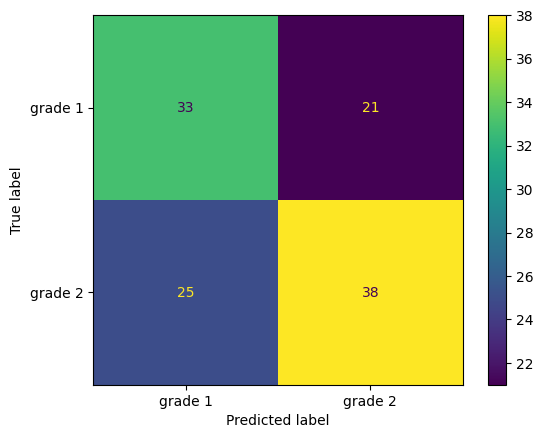

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['grade 1','grade 2'])
disp.plot()

**Confusion Matrix**            
in confusion matrix we have:             
C(0,0) = TN             
C(1,0) = FN              
C(1,1) = TP               
C(0,1) =  FP    

**sensitivity or true positive rate (TPR):**
$$sensitivity =\frac {TP}{TP + FN}=1-FNR$$             

**specificity or true negative rate (TNR):**
$$specificity =\frac{TN}{TN + FP}=1-FPR$$    

In [19]:
TN = cm[0,0]
FN = cm[1,0]
TP = cm[1,1]
FP = cm[0,1]
sens = TP/(TP+FN)
spc = TN/(TN+FP)
print('sensitivity = ', sens, 'specificity = ', spc)

sensitivity =  0.6031746031746031 specificity =  0.6111111111111112


auc value: 0.646384479717813


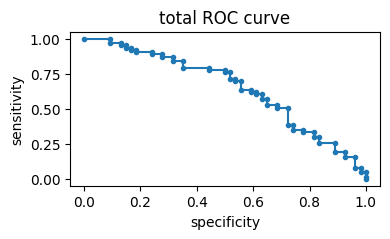

In [20]:
fpr, tpr, thresholds  = roc_curve(result_df['grade'], np.ravel(result_df['prob']))    #compare annotaion file labels with classifier prediction result 
sensitivity = tpr
specificity = 1-fpr

plt.figure(figsize=(4,2))
plt.plot(specificity, sensitivity, marker='.')
plt.title('total ROC curve')
plt.xlabel('specificity')
plt.ylabel('sensitivity')
auc_value = metrics.auc(fpr, tpr)
print('auc value:', auc_value)
plt.show()